# Discrete Anomaly Detection Exercises

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import math

import warnings
warnings.filterwarnings('ignore')

# 1. Use basic probability to identify anomalous request methods. You will want to make sure the text is normalized in order to reduce the noise.

In [2]:
#Acquire the data
colnames=['ip', 'timestamp', 'request_method', 'status', 'size',
          'destination', 'request_agent']
df_orig = pd.read_csv('http://python.zach.lol/access.log',          
                 engine='python',
                 header=None,
                 index_col=False,
                 names=colnames,
                 sep=r'\s(?=(?:[^"]*"[^"]*")*[^"]*$)(?![^\[]*\])',
                 na_values='"-"',
                 usecols=[0, 3, 4, 5, 6, 7, 8]
)

new = pd.DataFrame([["95.31.18.119", "[21/Apr/2019:10:02:41+0000]", 
                     "GET /api/v1/items/HTTP/1.1", 200, 1153005, np.nan, 
                     "python-requests/2.21.0"],
                    ["95.31.16.121", "[17/Apr/2019:19:36:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 301, 1005, np.nan, 
                     "python-requests/2.21.0"],
                    ["97.105.15.120", "[18/Apr/2019:19:42:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 301, 2560, np.nan, 
                     "python-requests/2.21.0"],
                    ["97.105.19.58", "[19/Apr/2019:19:42:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 200, 2056327, np.nan, 
                     "python-requests/2.21.0"]], columns=colnames)

df = df_orig.append(new)

In [3]:
df.head()

,ip,timestamp,request_method,status,size,destination,request_agent
0,97.105.19.58,[16/Apr/2019:19:34:42 +0000],"""GET /api/v1/sales?page=81 HTTP/1.1""",200,512495,NaN,"""python-requests/2.21.0"""
1,97.105.19.58,[16/Apr/2019:19:34:42 +0000],"""GET /api/v1/items HTTP/1.1""",200,3561,NaN,"""python-requests/2.21.0"""
2,97.105.19.58,[16/Apr/2019:19:34:44 +0000],"""GET /api/v1/sales?page=82 HTTP/1.1""",200,510103,NaN,"""python-requests/2.21.0"""
3,97.105.19.58,[16/Apr/2019:19:34:46 +0000],"""GET /api/v1/sales?page=83 HTTP/1.1""",200,510003,NaN,"""python-requests/2.21.0"""
4,97.105.19.58,[16/Apr/2019:19:34:48 +0000],"""GET /api/v1/sales?page=84 HTTP/1.1""",200,511963,NaN,"""python-requests/2.21.0"""


## Prepare Data

In [4]:
#convert timestamp to a human readable format
df.timestamp = df.timestamp.str.replace(r'(\[|\+0000\])', '', regex=True)

#convert timestame to datetime dtype
df.timestamp= pd.to_datetime(df.timestamp.str.replace(':', ' ', 1)) 

#set timestamp as index
df = df.set_index('timestamp')

In [5]:
#Cleanup text columns
for col in ['request_method', 'request_agent', 'destination']:
    df[col] = df[col].str.replace('"', '')

df['request_method'] = df.request_method.str.replace(r'\?page=[0-9]+', '', regex=True)

df.head()


,ip,request_method,status,size,destination,request_agent
timestamp,,,,,,
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,512495,NaN,python-requests/2.21.0
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/items HTTP/1.1,200,3561,NaN,python-requests/2.21.0
2019-04-16 19:34:44,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510103,NaN,python-requests/2.21.0
2019-04-16 19:34:46,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510003,NaN,python-requests/2.21.0
2019-04-16 19:34:48,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,511963,NaN,python-requests/2.21.0


In [6]:
#convert data in size from bytes to mb
df['size_mb'] = [n/1024/1024 for n in df['size']]

In [7]:
#check anomalies in request method by looking at request method where the prob is less than .01
rm_df = pd.DataFrame(df.request_method.value_counts(dropna=False)).reset_index().\
                rename(index=str, columns={'index': 'request_method', 'request_method': 'rm_count'})
rm_df2 = pd.DataFrame(df.request_method.value_counts(dropna=False)/df.request_method.count()).reset_index().\
                rename(index=str, columns={'index': 'request_method', 'request_method': 'rm_proba'})
rm_df = rm_df.merge(rm_df2)


# see those where rate < 1% 
rm_df[rm_df.rm_proba < .01]

,request_method,rm_count,rm_proba
3,GET / HTTP/1.1,107,0.007655
4,GET /documentation HTTP/1.1,100,0.007154
5,GET /favicon.ico HTTP/1.1,26,0.001860
6,GET /api/v1//api/v1/items HTTP/1.1,11,0.000787
7,GET /api/v1/items/api/v1/items HTTP/1.1,7,0.000501
8,GET /api/v1/items/next_page HTTP/1.1,5,0.000358
9,GET /api/v1/ HTTP/1.1,4,0.000286
10,GET /api/v1/sales/ HTTP/1.1,3,0.000215
11,GET /api/v1/sales/HTTP/1.1,3,0.000215
12,GET /api/v1/store HTTP/1.1,3,0.000215


22
                                  request_method  rm_count  rm_proba
12                    GET /api/v1/store HTTP/1.1         3  0.000215
13               GET /api/v1/itemsitems HTTP/1.1         3  0.000215
14                     GET /api/v1items HTTP/1.1         2  0.000143
15              GET /api/v1/helloclass! HTTP/1.1         1  0.000072
16                  GET /api/V1/HiZach! HTTP/1.1         1  0.000072
17                          GET /api/v1 HTTP/1.1         1  0.000072
18        GET /api/v1/I_DIDNT_DO_IT!!!! HTTP/1.1         1  0.000072
19                    GET /api/v1/items/HTTP/1.1         1  0.000072
20             GET /api/v1/items&page=0 HTTP/1.1         1  0.000072
21  GET /api/v1//api/v1/items/next_page HTTP/1.1         1  0.000072


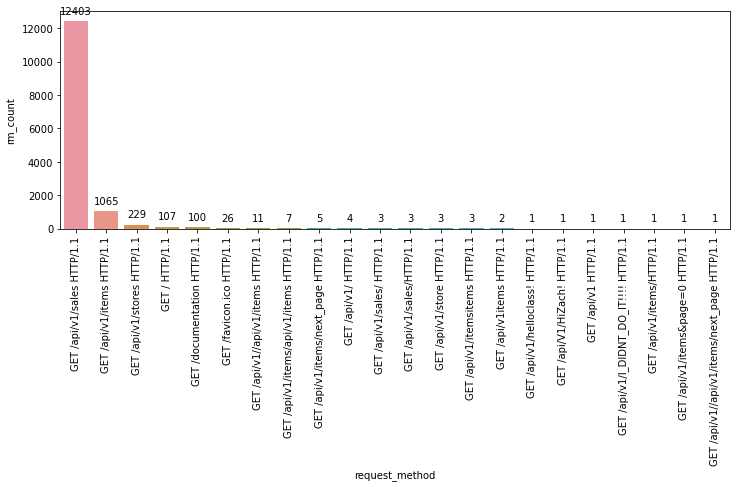

In [8]:
#Plot the request methods to visualize potential anomalies
print(len(rm_df))

print(rm_df.tail(10))

plt.figure(figsize=(12, 4))
splot = sns.barplot(data=rm_df, x = 'request_method', y = 'rm_count', ci = None)
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', xytext = (0, 10), 
                   textcoords = 'offset points'
                   )
    plt.xticks(rotation='vertical')

**Establish a baseline**

In [11]:
#Split the data and define the train data set
train = df.loc['2019-04-16 19:34:42':'2019-04-17 12:55:14']
train = train[['ip','request_method','status','size','destination','request_agent','size_mb']]

In [12]:
#Compute probabilities on Train dataset
rm_df = pd.DataFrame(train.request_method.value_counts(dropna=False)/train.request_method.count()).reset_index().\
                rename(index=str, columns={'index': 'request_method', 'request_method': 'rm_proba'})

In [13]:
#Merge train probabilities with full data set
df = df.reset_index().merge(rm_df, on=['request_method'], how='left').fillna(value=0).set_index('timestamp')
df.rm_proba.value_counts()

0.887577    12403
0.076213     1065
0.016388      229
0.007657      107
0.007156      100
0.001861       26
0.000787       11
0.000215        9
0.000501        7
0.000072        6
0.000358        5
0.000286        4
0.000000        4
0.000143        2
Name: rm_proba, dtype: int64

**Probability of Status given Request Method**

In [15]:
rm_probs = train.groupby('request_method').size().div(len(df))

status_given_rm = pd.DataFrame(train.groupby(['request_method', 'status']).\
                               size().div(len(train)).\
                               div(rm_probs, 
                                   axis=0, 
                                   level='request_method').\
                               reset_index().\
                               rename(index=str, 
                                      columns={0: 'proba_status_given_rm'})
                              )

In [17]:
rm_status_count = pd.DataFrame(train.groupby(['request_method', 'status'])['request_agent'].\
                                count().reset_index().\
                                rename(index=str, 
                                       columns={'request_agent': 'rm_status_count'}))


ip_status = status_given_rm.merge(rm_status_count)

In [20]:
df = df.reset_index().merge(ip_status, on=['request_method', 'status'], how='left').fillna(value=0).set_index('timestamp')

In [23]:
df.sample(20)

,ip,request_method,status,size,destination,request_agent,size_mb,rm_proba,proba_status_given_rm,rm_status_count
timestamp,,,,,,,,,,
2019-04-17 01:56:19,173.173.113.51,GET /api/v1/sales HTTP/1.1,200,510134,0,python-requests/2.21.0,0.486502,0.887577,0.999318,12391.0
2019-04-16 20:15:18,97.105.19.58,GET /api/v1/items HTTP/1.1,200,3561,0,python-requests/2.21.0,0.003396,0.076213,0.996529,1061.0
2019-04-17 05:14:39,173.173.113.51,GET /api/v1/sales HTTP/1.1,200,510134,0,python-requests/2.21.0,0.486502,0.887577,0.999318,12391.0
2019-04-16 20:12:24,97.105.19.58,GET /api/v1/items HTTP/1.1,200,3561,0,python-requests/2.21.0,0.003396,0.076213,0.996529,1061.0
2019-04-16 21:49:41,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,505155,0,python-requests/2.21.0,0.481753,0.887577,0.999318,12391.0
2019-04-16 21:37:38,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,130921,0,python-requests/2.21.0,0.124856,0.887577,0.999318,12391.0
2019-04-16 20:50:27,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510540,0,python-requests/2.21.0,0.486889,0.887577,0.999318,12391.0
2019-04-16 19:41:46,97.105.19.58,GET /api/v1/items HTTP/1.1,200,3561,0,python-requests/2.21.0,0.003396,0.076213,0.996529,1061.0
2019-04-16 20:03:36,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510217,0,python-requests/2.20.1,0.486581,0.887577,0.999318,12391.0


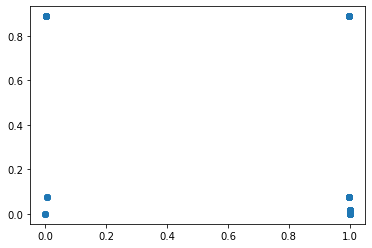

In [24]:
plt.scatter(df.proba_status_given_rm, df.rm_proba)